# HBR transfer example

Welcome to this example/tutorial notebook that will go through the fitting, evaluation, and transfering of HBR models. 

### Imports

In [1]:
# Need to install graphviz for the graphical model visualization
# %conda install -c conda-forge python-graphviz graphviz

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.normative_model.norm_factory import load_normative_model
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.param2 import make_param, Param
from pcntoolkit.regression_model.hbr.hbr import HBR
from pcntoolkit.util.plotter import plot_centiles, plot_qq
import seaborn as sns
import arviz as az
import os
import pymc as pm


# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [3]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)

In [4]:
data = pd.read_csv("resources/data/fcon1000.csv")

Plot the distribution of sex and site in the data.

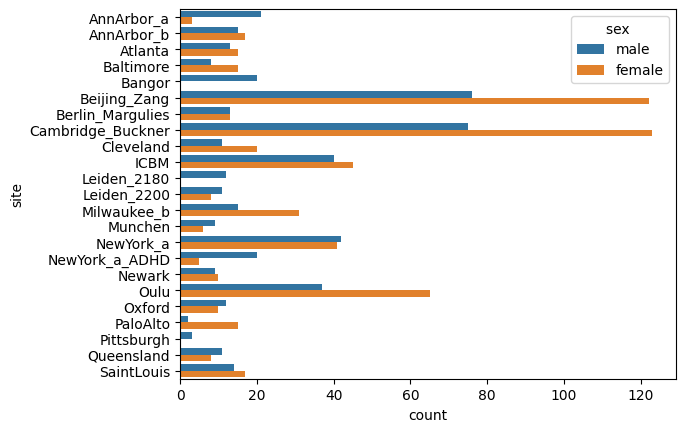

In [5]:
data["sex "] = np.where(data["sex"] == 1, ["male"], ["female"])
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()

Our HBR models will use random effects to model differences between sites. Because the random effects are best captured when there are enough samples of each effect in the data, we will have to remove some sites that are too small. We will filter out sites for which any of the sexes is represented by less than 10 samples

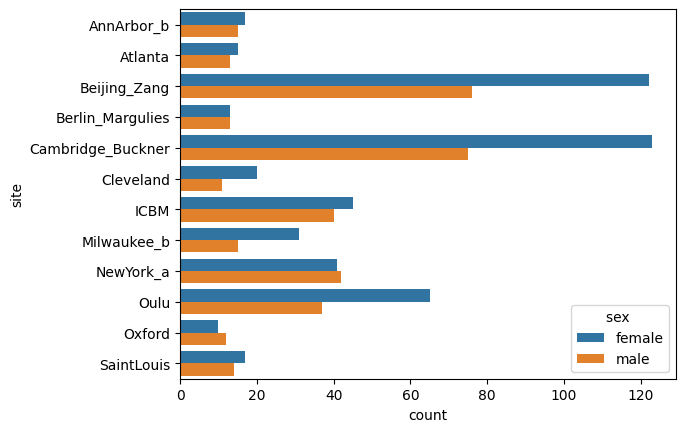

In [6]:
site_counts = data.groupby(["site", "sex"]).size().reset_index(name="counts")  # type: ignore
sex_count_per_site = site_counts["site"].value_counts()
sites_with_one_sex = sex_count_per_site[sex_count_per_site == 1]
sites_with_one_sex.index
data = data[~data["site"].isin(sites_with_one_sex.index)]
site_counts = site_counts[site_counts["counts"] < 10]
data = data[~data["site"].isin(site_counts["site"])]
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()


Now we load the data into a `NormData` object. 

In [7]:
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

We will use 2 sites for transfer (Milwaukee and Oulu) and the rest for training.

In [8]:
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects(
    {"site": transfer_sites}, names=["transfer", "fit"]
)


We also split the data into train and test sets.

In [9]:
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. Our `NormConf` configuration contains canonical paths, a standardization step for both the input as as the output data, and a Bspline basis expansion.

In [10]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir="resources/hbr/save_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

Configuration of normative model is valid.


## Configure the regression model

HBR models need to specificy (possibly recursive) parameter configurations. Here, we configure a HBR model with a SHASHb likelihood, a bspline regression in `mu` and `sigma`, and a random effect in the intercept of `mu`. Note that because sigma has to be strictly positive, we specify a `softplus` mapping, so that the output of the linear regression is mapped to the positive domain. 

In [11]:
mu = make_param(
    name="mu",
    linear=True,
    slope=make_param(dist_name="Normal", dist_params=(0.0, 5.0)),
    intercept=make_param(
        random=True,
        sigma=make_param(dist_name="HalfNormal", dist_params=(1.0,)),
        mu=make_param(dist_name="Normal", dist_params=(0.0, 0.5)),
    ),
)
sigma = make_param(
    name="sigma",
    linear=True,
    slope=make_param(dist_name="Normal", dist_params=(0.0, 3.0)),
    intercept=make_param(
        dist_name="Normal",
        dist_params=(
            1.0,
            1.0,
        ),
    ),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
)


# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=1500,
    tune=500,
    chains=4,
    pymc_cores=16,
    likelihood="Normal",
    mu=mu,
    sigma=sigma,
    nuts_sampler="nutpie",
    init="jitter+adapt_diag",
)

## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [12]:
# Using the constructor
norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
display(norm_hbr)
del norm_hbr

In [13]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)
norm_hbr

## Fit the model
With all our configuration done, we can fit our model on the train data. 

In [14]:
predictions = norm_hbr.fit_predict(train, test)

Going to fit and predict 2 models
Fitting and predicting model for rh_MeanThickness_thickness


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Tensor3(float64, shape=(?, ?, 1)) (of Variable Reshape{3}.0) into Type Matrix(float64, shape=(?, 1)). You can try to manually convert Reshape{3}.0 into a Matrix(float64, shape=(?, 1)). ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSubtensor(ExpandDims{axis=0}.0, [[0]], Clip.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1959, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/features.py", line 627, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,75,0.17,63
,2000,69,0.16,95
,2000,117,0.16,63
,2000,39,0.15,31


Sampling: [y_pred]


Output()

Fitting and predicting model for WM-hypointensities


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Tensor3(float64, shape=(?, ?, 1)) (of Variable Reshape{3}.0) into Type Matrix(float64, shape=(?, 1)). You can try to manually convert Reshape{3}.0 into a Matrix(float64, shape=(?, 1)). ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSubtensor(ExpandDims{axis=0}.0, [[0]], Clip.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1959, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/features.py", line 627, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,68,0.16,31
,2000,51,0.15,31
,2000,27,0.15,31
,2000,558,0.15,95


Sampling: [y_pred]


Output()

40508 Saving model to resources/hbr/save_dir


Sampling: [y_pred]


Output()

Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir/model
Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing zscores for WM-hypointensities


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir/plots


As we can see, the model is saved to the save_dir specified in the norm_conf. We can inspect that folder to find three subfolders:
- `model`: contains the model and metadata
- `results`: containing csv files with the evaluation results for all response variables
- `plots`: containing qq plots and centile plots for each response variable

## Inspecting the model 

The norm_hbr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_hbr.regression_models.get("{responsevar}")`

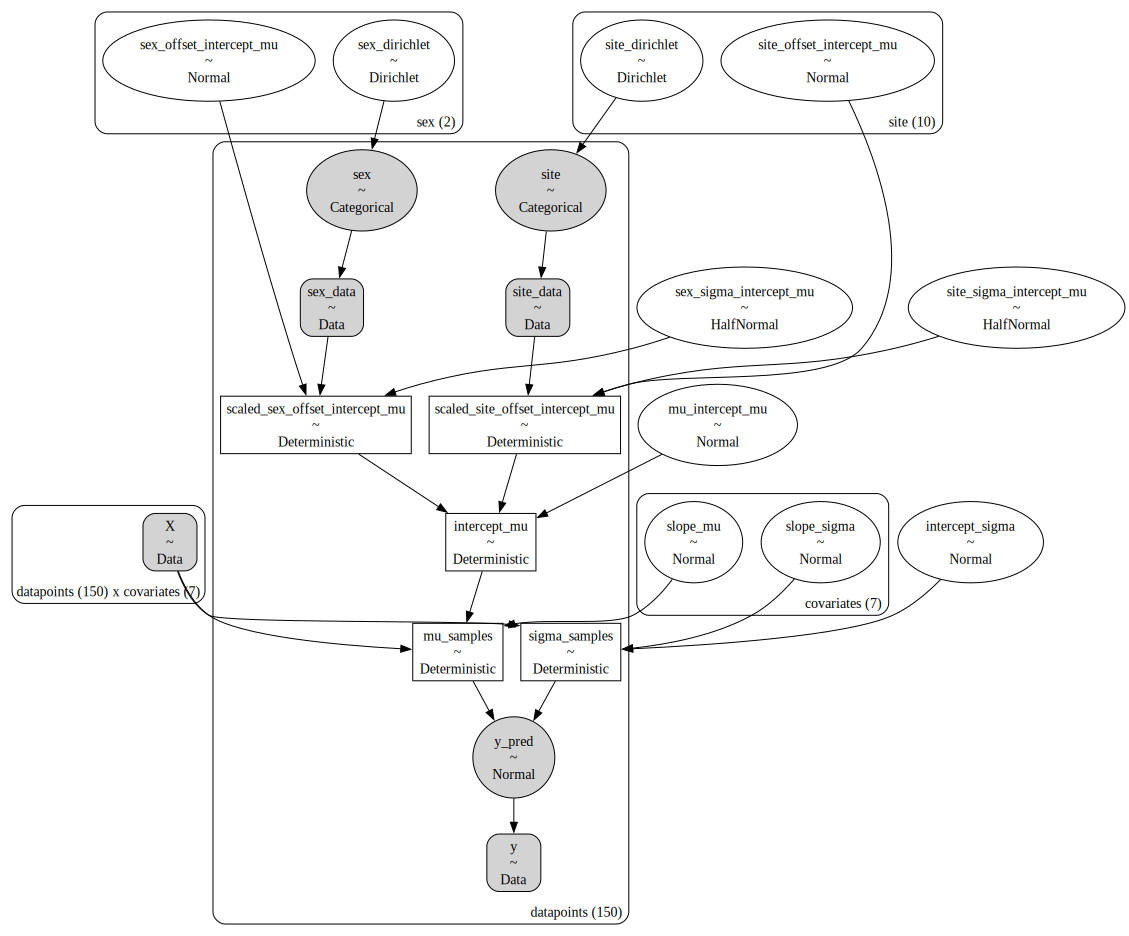

In [15]:
model: HBR = norm_hbr.regression_models.get("rh_MeanThickness_thickness")  # type: ignore
model.pymc_model.to_graphviz()  # type: ignore

We can use the arviz library to inspect the posterior samples (trace) of the model. Here we only use the 'plot_trace' function to inspect the trace of the model, but there are many other useful functions available. If you are not familiar with arviz, we recommend checking out the [arviz documentation](https://arviz-devs.github.io/arviz/index.html).


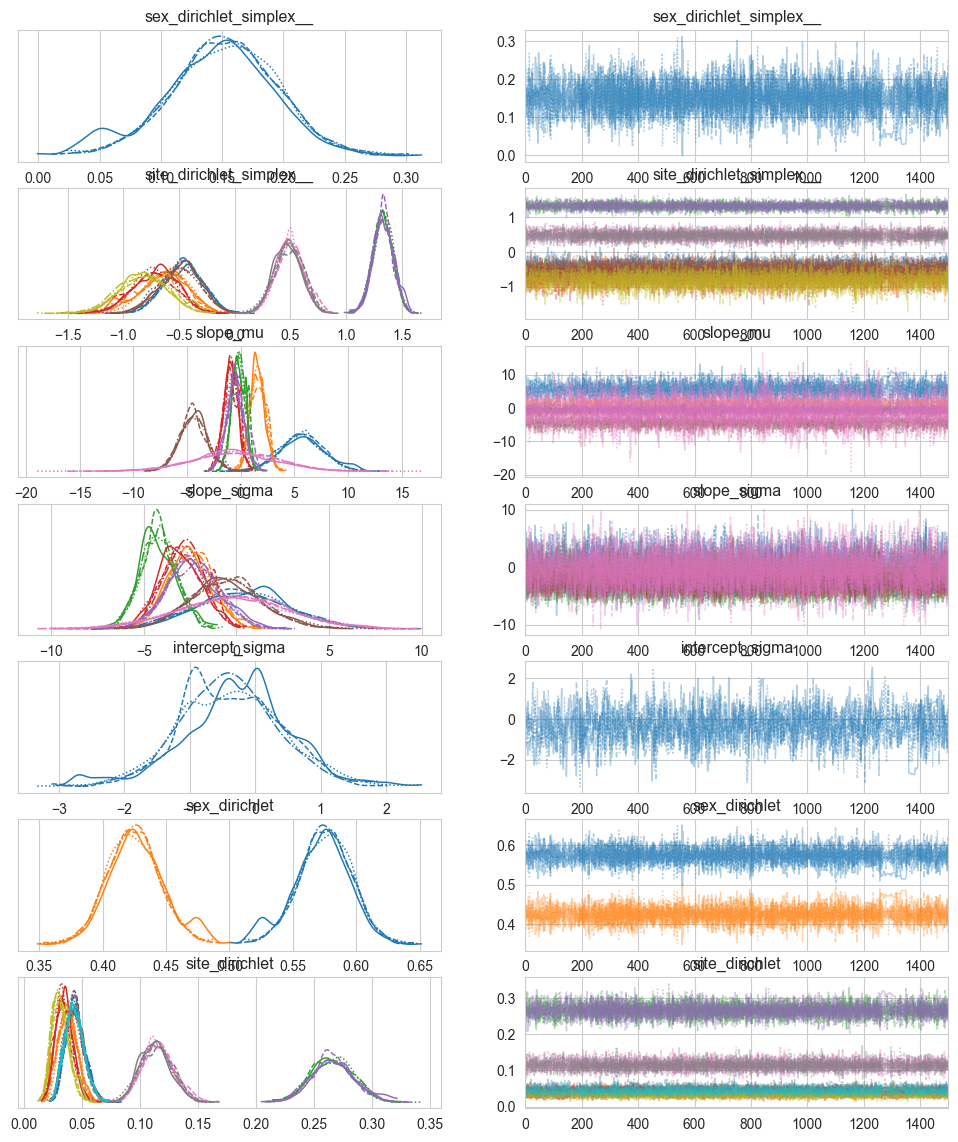

In [16]:
idata = model.idata  # type: ignore
# az.style.use("arviz-doc")
plt.rcParams["figure.figsize"] = (10, 10)
# plt.tight_layout()
az.plot_trace(
    idata.posterior, var_names=["~_samples", "~intercept_mu"], filter_vars="like"
)
plt.show()

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [17]:
display(test.measures.to_pandas().T)


response_vars,rh_MeanThickness_thickness,WM-hypointensities
statistics,,
Rho,0.520540,0.394357
RMSE,0.075139,499.656574
SMSE,0.580387,0.765516
ExpV,0.420126,0.243083
NLL,NaN,NaN
ShapiroW,0.992650,0.973577


Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [18]:
display(test.zscores.to_pandas())  # the zscores

response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
124,0.618657,1.010586
48,-0.409278,-0.619640
545,0.323281,0.205882
847,1.144222,0.415126
360,-2.138236,-0.393579
...,...,...
688,-1.169628,0.107629
420,0.692502,1.094991
123,-0.844639,-1.234077


In [19]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
124                             2.373630         415.542623   
48                              2.323800         315.337870   
545                             2.325440        -484.918304   
847                             2.361372         450.477956   
360                             2.358331         779.173273   
...                                  ...                ...   
688                             2.332402         313.775340   
420                             2.384701         651.163691   
123                             2.396287         608.526140   
276                             2.423287         100.714572   
183                             2.386680         437.688841   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
124                             2.439599         767.205084   
48                              2.389769         667.000331   
545                             2.414560         759.127976   
847                             2.425845         872.649617   
360                             2.424300        1130.835734   
...                                  ...                ...   
688                             2.398729         792.569445   
420                             2.456653         976.038153   
123                             2.463993         944.135012   
276                             2.487593         501.507647   
183                             2.454386         773.297713   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.50               0.50   
datapoints                                                    
124                             2.485453        1011.641971   
48                              2.435624         911.437218   
545                             2.476506        1623.851493   
847                             2.470659        1166.096709   
360                             2.470155        1375.272621   
...                                  ...                ...   
688                             2.444832        1125.374204   
420                             2.506666        1201.854983   
123                             2.511055        1177.413218   
276                             2.532292         780.094709   
183                             2.501448        1006.575920   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.75               0.75   
datapoints                                                    
124                             2.531308        1256.078858   
48                              2.481478        1155.874105   
545                             2.538452        2488.575011   
847                             2.515474        1459.543802   
360                             2.516009        1619.709508   
...                                  ...                ...   
688                             2.490935        1458.178963   
420                             2.556678        1427.671814   
123                             2.558117        1410.691424   
276                             2.576991        1058.681771   
183                             2.548510        1239.854126   

                                                             
response_vars rh_MeanThickness_thickness WM-hypointensities  
cdf                                 0.95               0.95  
datapoints                                                   


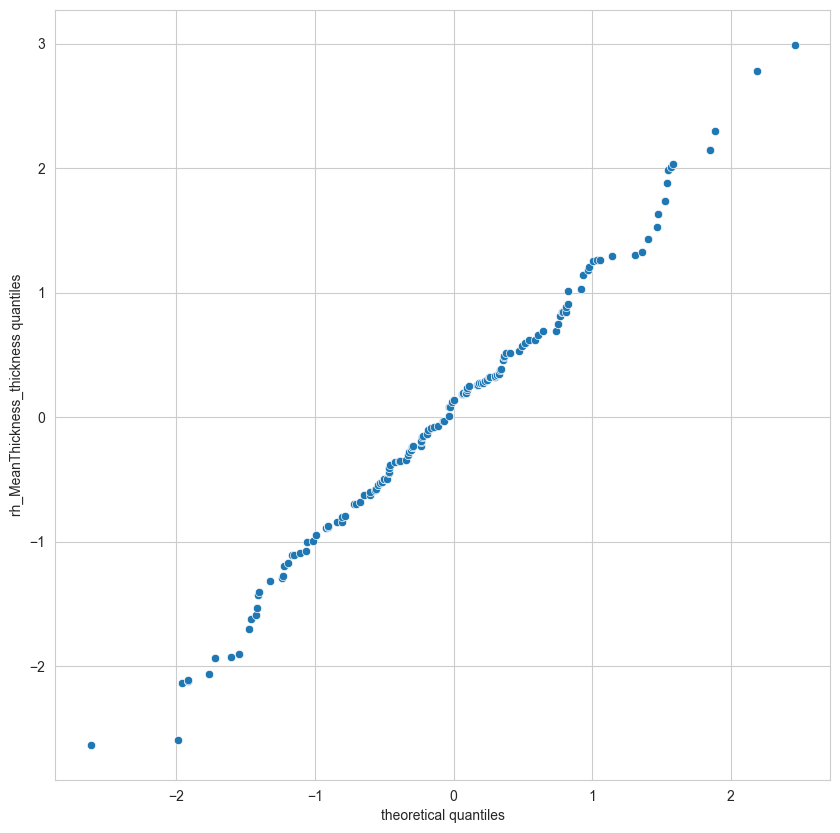

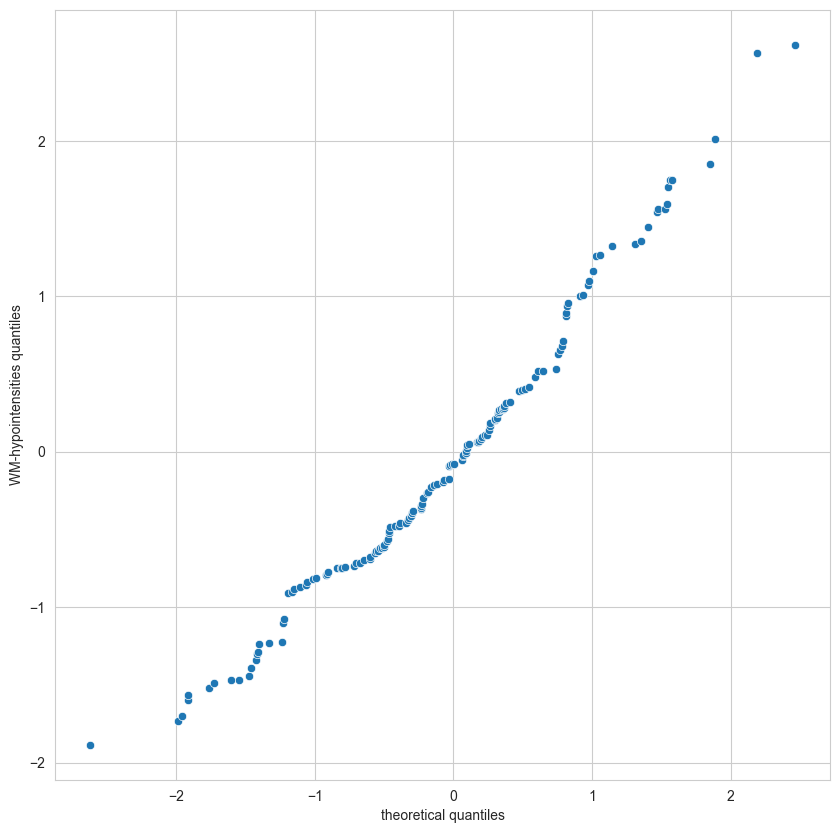

In [20]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


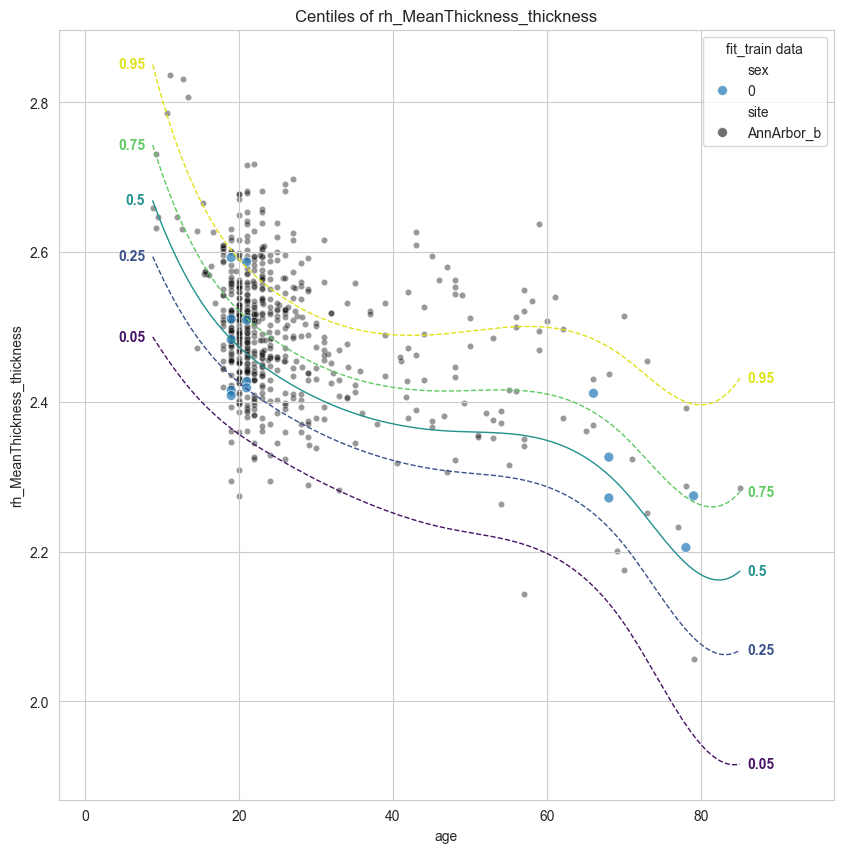

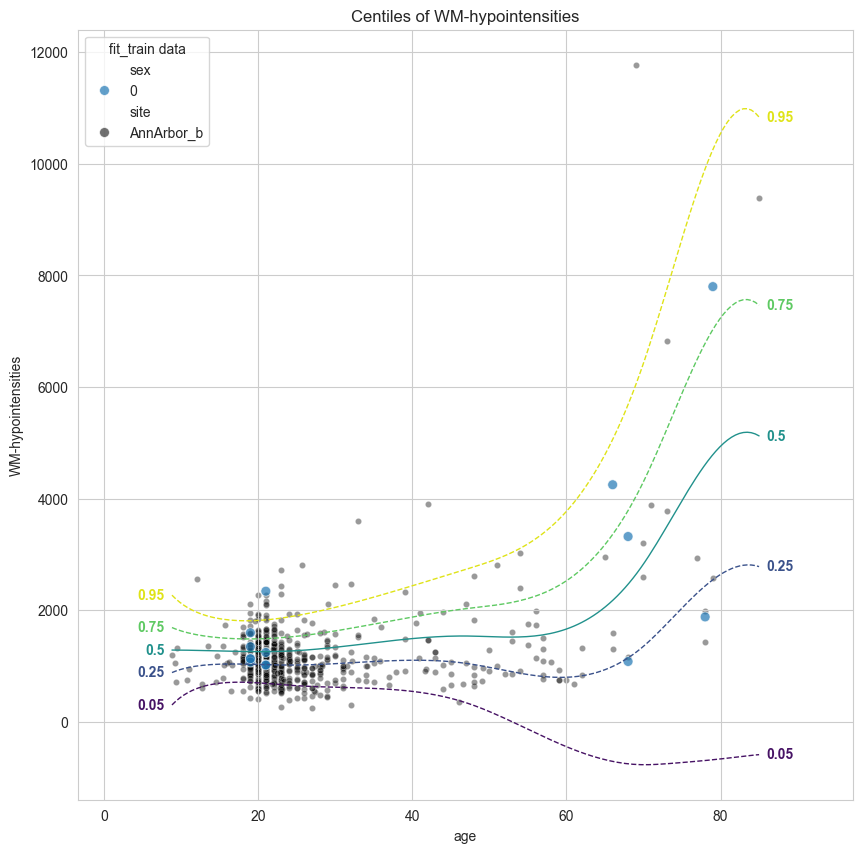

In [21]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


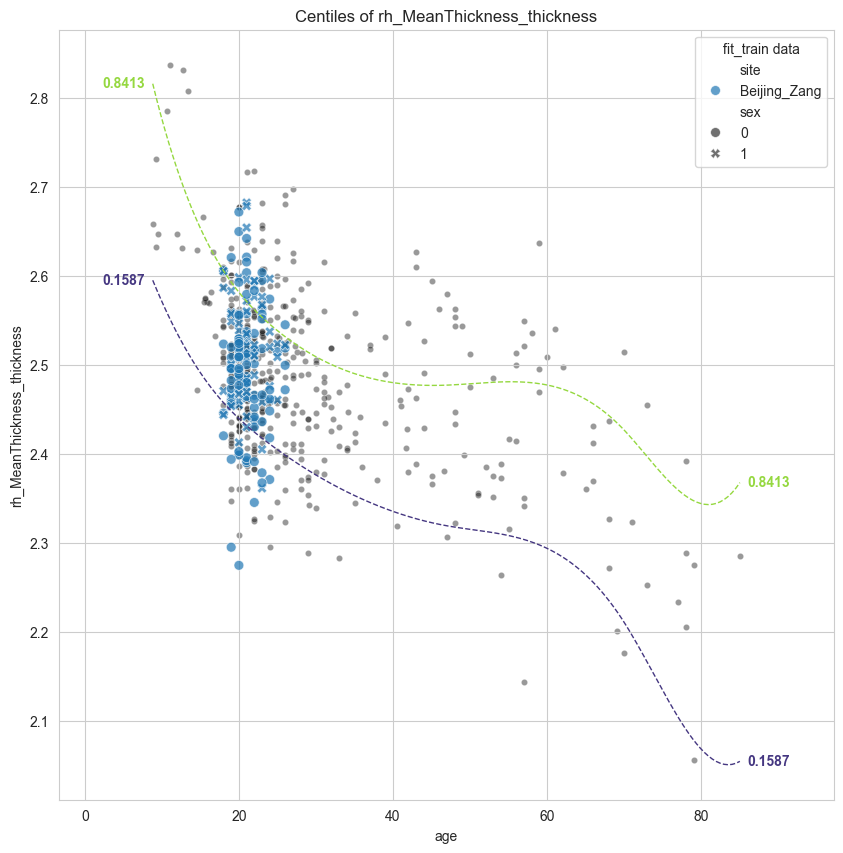

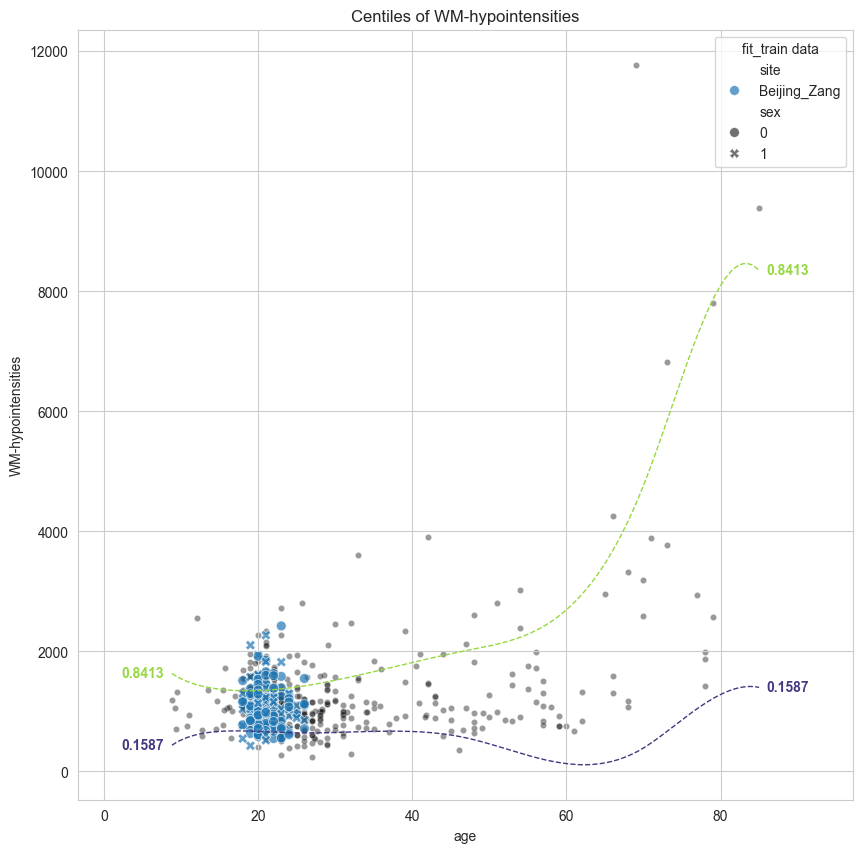

In [22]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    cummul_densities=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["Beijing_Zang"]},
)

### Getting posterior predictive samples


In [23]:
with model.pymc_model:
    post_pred = pm.sample_posterior_predictive(model.idata.posterior)

post_pred


Sampling: [sex, site, y_pred]


Output()

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

## Transfer

We transfer the model to the transfer_train dataset that we created before. The posterior distribution is factorized and a new RegConf is created using the factorized posterior as a prior. To give some extra control, we let the `freedom` parameter control the variance of the derived factorized posterior. With a `freedom` of 1, the factorized representation is used as is. With freedom of `2`, all derived prior distributions are widened by a factor of 2. 

In [24]:
transfered_model = norm_hbr.transfer(
    transfer_train, freedom=0.0001, nuts_sampler="nutpie"
)
# Caused by:
#     Logp function returned error: Logp function returned error code 4

Going to transfer 2 models
Transferring model for rh_MeanThickness_thickness


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Tensor3(float64, shape=(?, ?, 1)) (of Variable Reshape{3}.0) into Type Matrix(float64, shape=(?, 1)). You can try to manually convert Reshape{3}.0 into a Matrix(float64, shape=(?, 1)). ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSubtensor(ExpandDims{axis=0}.0, [[0]], Clip.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1959, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/features.py", line 627, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,1,0.55,7
,2000,0,0.60,7
,2000,0,0.60,7
,2000,0,0.57,7


Transferring model for WM-hypointensities


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Tensor3(float64, shape=(?, ?, 1)) (of Variable Reshape{3}.0) into Type Matrix(float64, shape=(?, 1)). You can try to manually convert Reshape{3}.0 into a Matrix(float64, shape=(?, 1)). ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSubtensor(ExpandDims{axis=0}.0, [[0]], Clip.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1959, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/features.py", line 627, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.58,7
,2000,0,0.54,7
,2000,0,0.56,7
,2000,0,0.53,7


Configuration of normative model is valid.
40508 Saving model to resources/hbr/save_dir_transfer
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/model


We can save, load, predict, and plot just as before. 

If the orinal save directory path was `{path}/{save_dir}`, then the transfered model's save directory path will be `{path}/{save_dir}_tansfer`, and the same holds for the log dir path

In [25]:
transfered_model.save()

40508 Saving model to resources/hbr/save_dir_transfer
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/model


In [26]:
os.makedirs("resources/save_dir_transfer", exist_ok=True)

In [27]:
transfered_model = load_normative_model("resources/hbr/save_dir_transfer")
transfered_predictions = transfered_model.predict(transfer_test)

Configuration of normative model is valid.
Configuration of normative model is valid.
Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Output()

Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing zscores for WM-hypointensities


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/plots


In [28]:
display(transfered_predictions.measures.to_pandas().T)
display(transfered_predictions.zscores.to_pandas())
display(
    transfered_predictions.centiles.to_dataframe().unstack(
        level=["response_vars", "cdf"]
    )
)

response_vars,rh_MeanThickness_thickness,WM-hypointensities
statistics,,
Rho,0.552341,-0.242310
RMSE,0.087652,842.771334
SMSE,1.016461,3.408798
ExpV,0.000002,-0.000002
NLL,NaN,NaN
ShapiroW,0.984456,0.940690


response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
794,-0.142058,-0.531958
796,0.471665,-0.627574
758,0.380130,-0.165416
786,1.907879,-0.501092
746,-0.512099,-0.647421
749,0.388193,-0.729077
802,-0.380511,-0.969664
812,0.594924,-0.793978
730,-0.061244,-0.536032


centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
794                             2.312616        -187.386202   
796                             2.312616        -187.386087   
758                             2.312616        -187.386653   
786                             2.312616        -187.386259   
746                             2.312616        -187.386769   
749                             2.312616        -187.386087   
802                             2.312616        -187.386087   
812                             2.312616        -187.386087   
730                             2.312616        -187.386653   
640                             2.312616        -187.391748   
607                             2.312616        -187.391877   
731                             2.312616        -187.386087   
641                             2.312616        -187.389154   
750                             2.312616        -187.386087   
638                             2.312616        -187.391344   
619                             2.312616        -187.391803   
826                             2.312616        -187.386202   
808                             2.312616        -187.386202   
740                             2.312616        -187.386769   
626                             2.312616        -187.389998   
807                             2.312616        -187.386202   
800                             2.312616        -187.386769   
608                             2.312616        -187.389321   
613                             2.312616        -187.391182   
774                             2.312616        -187.386087   
599                             2.312616        -187.392473   
747                             2.312616        -187.386769   
816                             2.312616        -187.386653   
751                             2.312616        -187.386769   
819                             2.312616        -187.386202   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
794                             2.422124        1098.432407   
796                             2.422124        1098.432333   
758                             2.422124        1098.431767   
786                             2.422124        1098.432569   
746                             2.422124        1098.431841   
749                             2.422124        1098.432333   
802                             2.422124        1098.432333   
812                             2.422124        1098.432333   
730                             2.422124        1098.431767   
640                             2.422123        1098.426654   
607                             2.422124        1098.426905   
731                             2.422124        1098.432333   
641                             2.422124        1098.430339   
750                             2.422124        1098.432333   
638                             2.422124        1098.427628   
619                             2.422124        1098.426760   
826                             2.422124        1098.432407   
808                             2.422124        1098.432407   
740                             2.422124        1098.431841   
626                             2.422124        1098.429103   
807                             2.422124        1098.432407   
800                             2.422124        1098.431841   
608                             2.422124        1098.430040   
613                             2.422124        1098.427220   
774                             2.422124        1098.432333   
599                             2.422124        1098.426139   

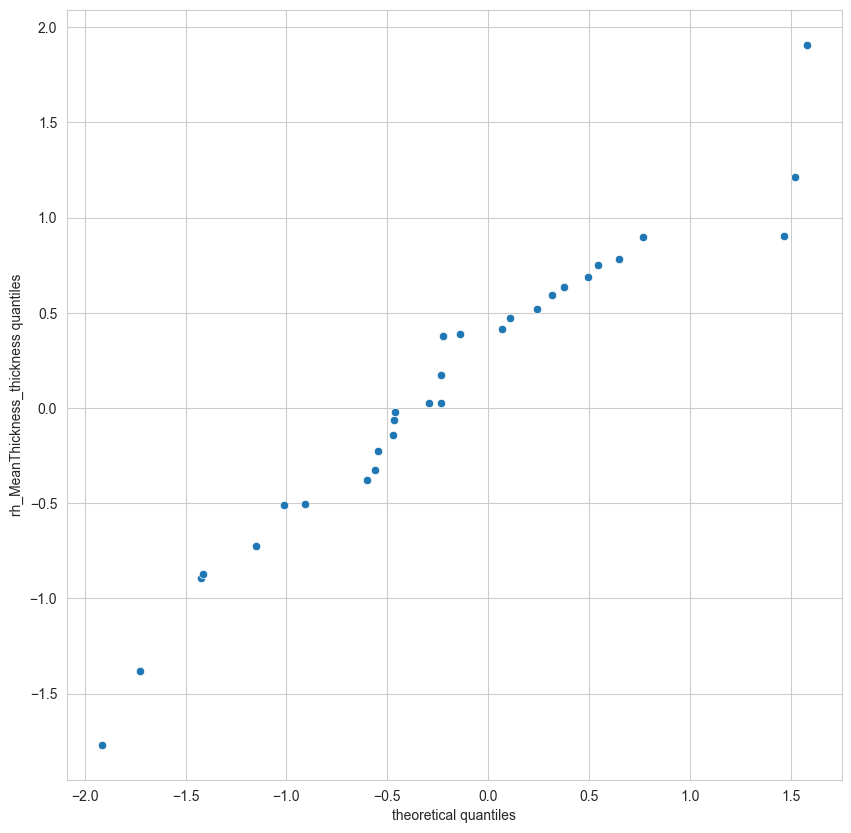

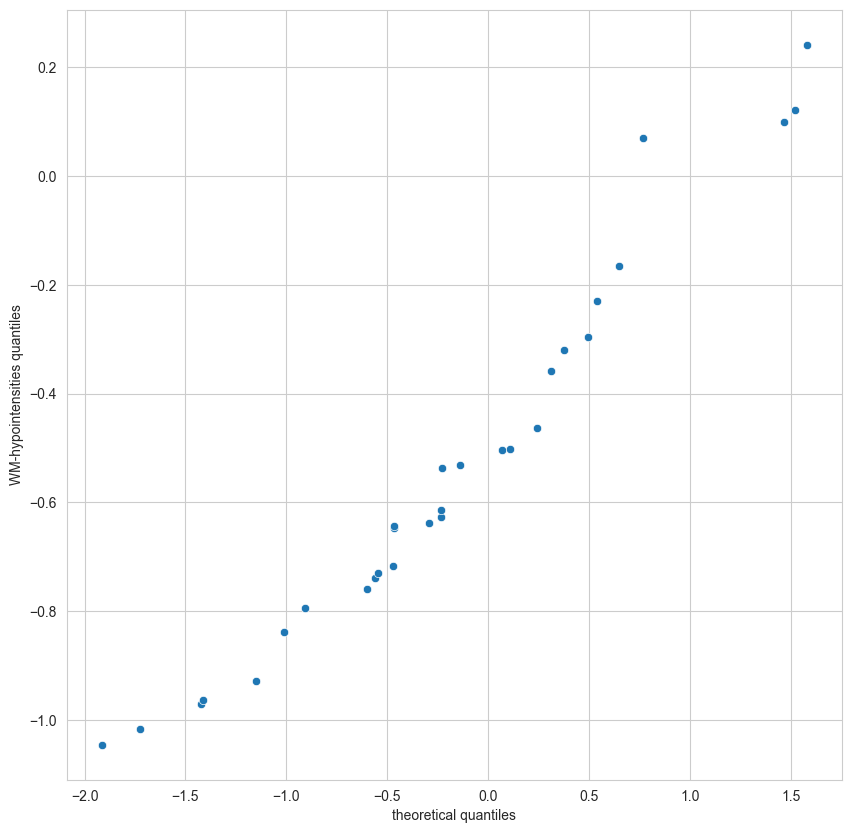

In [29]:
plot_qq(transfer_test)

Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


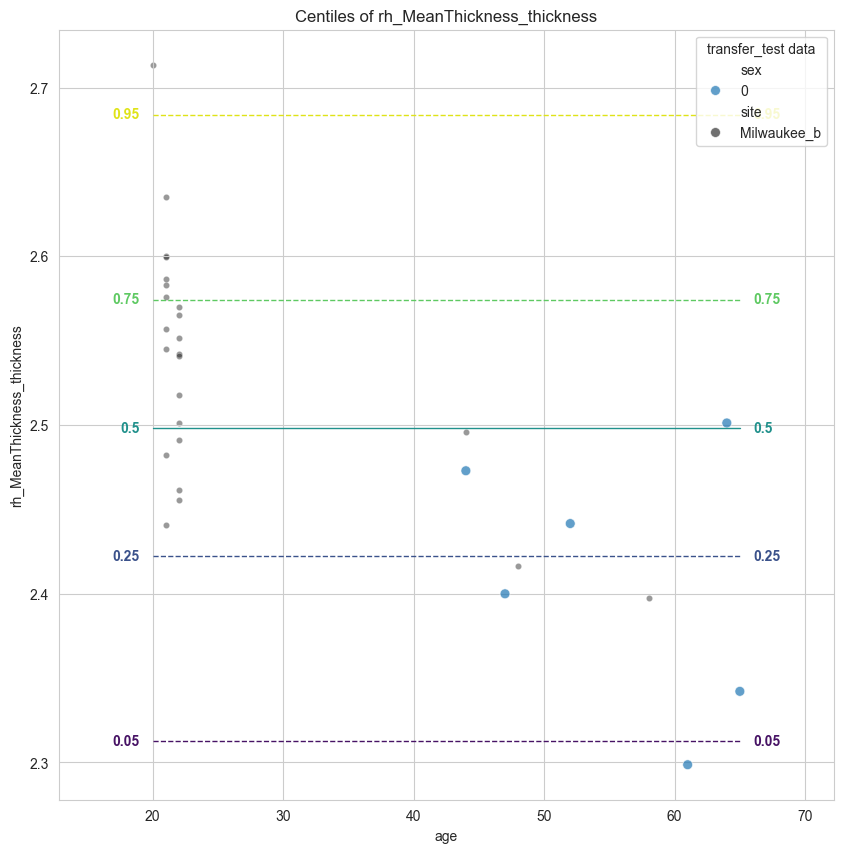

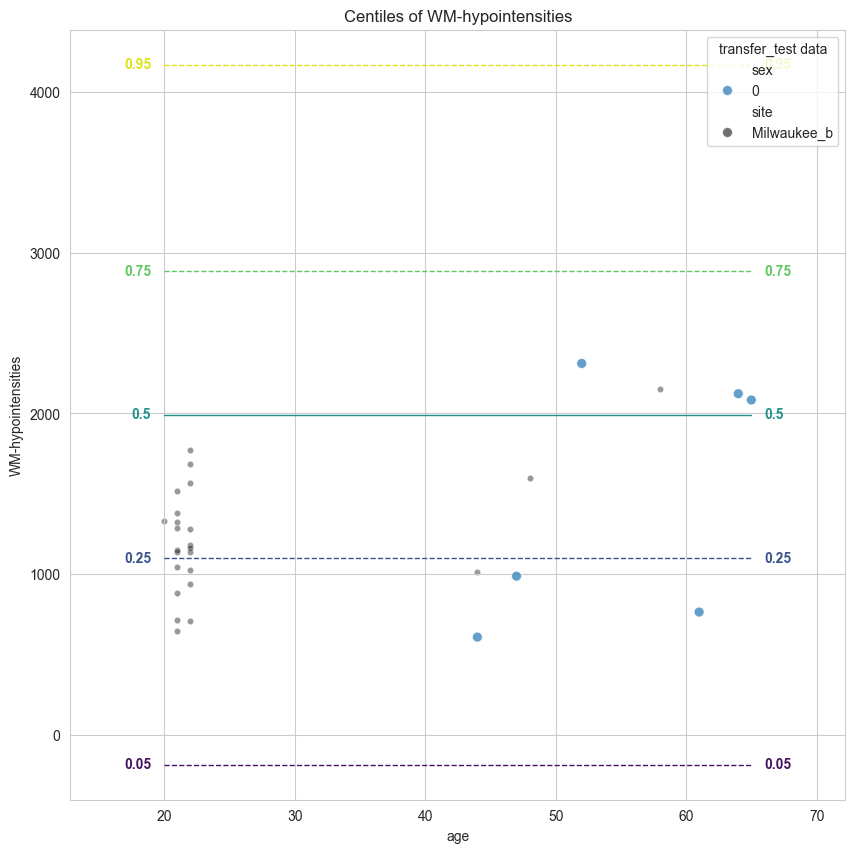

In [30]:
plot_centiles(
    transfered_model,
    transfer_test,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

And that's it, now you have seen how to:
- Use the NormData class to load in your data
- Create and fit a normative model
- Get the evaluation statistics, and create some useful plots
- Transfer the model to another dataset

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!